In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, initializers
from datetime import date
import numpy as np

# import competition_manager as cm
from competition_manager import *

In [2]:
import random
import os
def set_seed(seed=42):
    np.random.seed(seed)                  # Fix NumPy random seed
    random.seed(seed)                     # Fix Python built-in random seed
    tf.random.set_seed(seed)              # Fix TensorFlow random seed

    # Optional but recommended: configure TensorFlow for deterministic ops
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Call this function at the very start, before building or training your model
seed_value = 42
set_seed(seed_value)

## Generate synthetic teams and games

In [3]:
def calculate_team_strength(team_players):
    # Base strength sum
    strength = player_strengths[team_players].sum()
    print(f"Base strength of team {team_players}: {strength:.4f}")
    
    # Compute favorite player boost (fixed)
    for i, pair in enumerate(friend_pairs):
        if all(player in team_players for player in pair):
            boost = friend_pairs_boost[i]
            strength += boost
            print(f"Favorite pair boost applied for players {pair}: +{boost:.4f}, total strength now {strength:.4f}")
    for i, triplet in enumerate(friend_triplets):
        if all(player in team_players for player in triplet):
            boost = friend_triplets_boost[i]
            strength += boost
            print(f"Favorite triplet boost applied for players {triplet}: +{boost:.4f}, total strength now {strength:.4f}")
    
    # Compute skills boost correlated with players' average strength
    for i, pair in enumerate(skilled_pairs):
        if all(player in team_players for player in pair):
            avg_strength = player_strengths[list(pair)].mean()
            boost = skilled_pairs_boost[i] * avg_strength
            strength += boost
            print(f"Skills pair boost for players {pair}: avg strength {avg_strength:.4f} * boost factor {skilled_pairs_boost[i]:.4f} = +{boost:.4f}, total strength now {strength:.4f}")
    
    for i, triplet in enumerate(skilled_triplets):
        if all(player in team_players for player in triplet):
            avg_strength = player_strengths[list(triplet)].mean()
            boost = skilled_triplets_boost[i] * avg_strength
            strength += boost
            print(f"Skills triplet boost for players {triplet}: avg strength {avg_strength:.4f} * boost factor {skilled_triplets_boost[i]:.4f} = +{boost:.4f}, total strength now {strength:.4f}")
    
    return strength

In [4]:
np.random.seed(42)  # for reproducibility

NUM_PLAYERS = 30  # player 0 is ignore/masked and 1 is added to account for this
MIN_TEAM_SIZE = 5
MAX_TEAM_SIZE = 9
NUM_GAMES = 100

# 1. Generate players' strengths: single float number [0, 1]
player_strengths = np.random.rand(NUM_PLAYERS + 1) # player 0 is ignore/masked 

# 2. Generate favorite player pairs and triplets (friends)
num_friend_pairs = 10
num_friend_triplets = 5

# Randomly select unique pairs
friend_pairs = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS +1), size=2, replace=False)) for _ in range(num_friend_pairs)]
friend_pairs_boost = np.random.uniform(0.05, 0.15, size=num_friend_pairs)  # small boost

# Randomly select unique triplets
friend_triplets = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS +1), size=3, replace=False)) for _ in range(num_friend_triplets)]
friend_triplets_boost = np.random.uniform(0.1, 0.25, size=num_friend_triplets)  # larger boost

# 3. Generate skilled pairs and triplets (high skill synergy)
num_skilled_pairs = 8
num_skilled_triplets = 4

skilled_pairs = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS + 1), size=2, replace=False)) for _ in range(num_skilled_pairs)]
skilled_pairs_boost = np.random.uniform(0.1, 0.2, size=num_skilled_pairs)  # moderate boost

skilled_triplets = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS + 1), size=3, replace=False)) for _ in range(num_skilled_triplets)]
skilled_triplets_boost = np.random.uniform(0.15, 0.3, size=num_skilled_triplets)  # strong boost

# 2. Prepare arrays to hold the dataset
teamA_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
teamB_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
labels = np.zeros(NUM_GAMES)

def drop_zeroes_for_sum(players_strengths):
    return players_strengths[players_strengths !=0]

for game_i in range(NUM_GAMES):
    # Random sizes for both teams in [MIN_TEAM_SIZE, MAX_TEAM_SIZE]

    team_size = np.random.randint(MIN_TEAM_SIZE, MAX_TEAM_SIZE + 1)

    # Randomly sample distinct players for each team (sampling with replacement allowed for simplicity)
    # To avoid overlap if needed: sample without replacement from full 32 for both teams combined,
    # here assuming players can appear on both teams (as per original conversation)
    # teamA_players = np.random.choice(NUM_PLAYERS, size=teamA_size, replace=False)
    # teamB_players = np.random.choice(NUM_PLAYERS, size=teamB_size, replace=False)
    
    # Shuffle all players and split into two disjoint teams
    all_players = np.random.permutation(np.arange(1, NUM_PLAYERS + 1))
    teamA_players = all_players[:team_size]
    teamB_players = all_players[team_size:2*team_size]
    
    print(f"Game # {game_i} evaluation: ")
    # Compute team strengths as sum of player strengths
    teamA_strength = calculate_team_strength(teamA_players)
    teamB_strength = calculate_team_strength(teamB_players)
    print(f"=" * 50)
    
    # print(f"Team A strengths {player_strengths[teamA_players]} Total: {teamA_strength}")

    # Calculate match outcome: 1 if Team A wins, 0 if Team B wins
    # Add small noise to simulate unpredictability
    outcome = teamA_strength - teamB_strength + np.random.normal(scale=0.1)
    labels[game_i] = outcome

    # Pad teams to max size using zeros (which corresponds to masked player)
    teamA_data[game_i, :team_size] = teamA_players
    teamB_data[game_i, :team_size] = teamB_players

print("player_strengths shape:", player_strengths.shape)
print("teamA_data shape:", teamA_data.shape)
print("teamB_data shape:", teamB_data.shape)
print("labels shape:", labels.shape)

# Example print first 3 games
for i in range(3):
    print(f"Game {i}:")
    teamA_pls = teamA_data[i]
    print(" Team A players: ", teamA_pls)
    print(" Team A palyers' stregths: ", player_strengths[teamA_pls])

    teamB_pls = teamB_data[i]
    print(" Team B players: ", teamB_pls)
    print(f"Team B strengths {drop_zeroes_for_sum(player_strengths[teamB_pls]).sum()}")
    print(" Team B palyers' stregths: ", player_strengths[teamB_pls])
    print(" Label (Team A wins=1):", labels[i])


Game # 0 evaluation: 
Base strength of team [ 4  8 19 24 23  3 26  7 25]: 4.3205
Base strength of team [30 15 16 27 11 13 29 20 17]: 3.9747
Favorite pair boost applied for players (np.int64(30), np.int64(20)): +0.0999, total strength now 4.0747
Favorite pair boost applied for players (np.int64(11), np.int64(15)): +0.1495, total strength now 4.2241
Skills pair boost for players (np.int64(20), np.int64(11)): avg strength 0.7909 * boost factor 0.1480 = +0.1171, total strength now 4.3412
Game # 1 evaluation: 
Base strength of team [16  9 21  4  5  1  8 17  6]: 3.5985
Favorite pair boost applied for players (np.int64(16), np.int64(4)): +0.1072, total strength now 3.7057
Favorite pair boost applied for players (np.int64(16), np.int64(8)): +0.1269, total strength now 3.8325
Base strength of team [10 26 12 11 30 18 28  3  7]: 5.1193
Skills pair boost for players (np.int64(10), np.int64(12)): avg strength 0.4265 * boost factor 0.1377 = +0.0587, total strength now 5.1781
Game # 2 evaluation: 
Ba

## Version of the model for generated data

Note that embedding_regulazer can change embeddings for the zero-player that is otherwise behind a padding value ( and not supposed to be being changed during training).
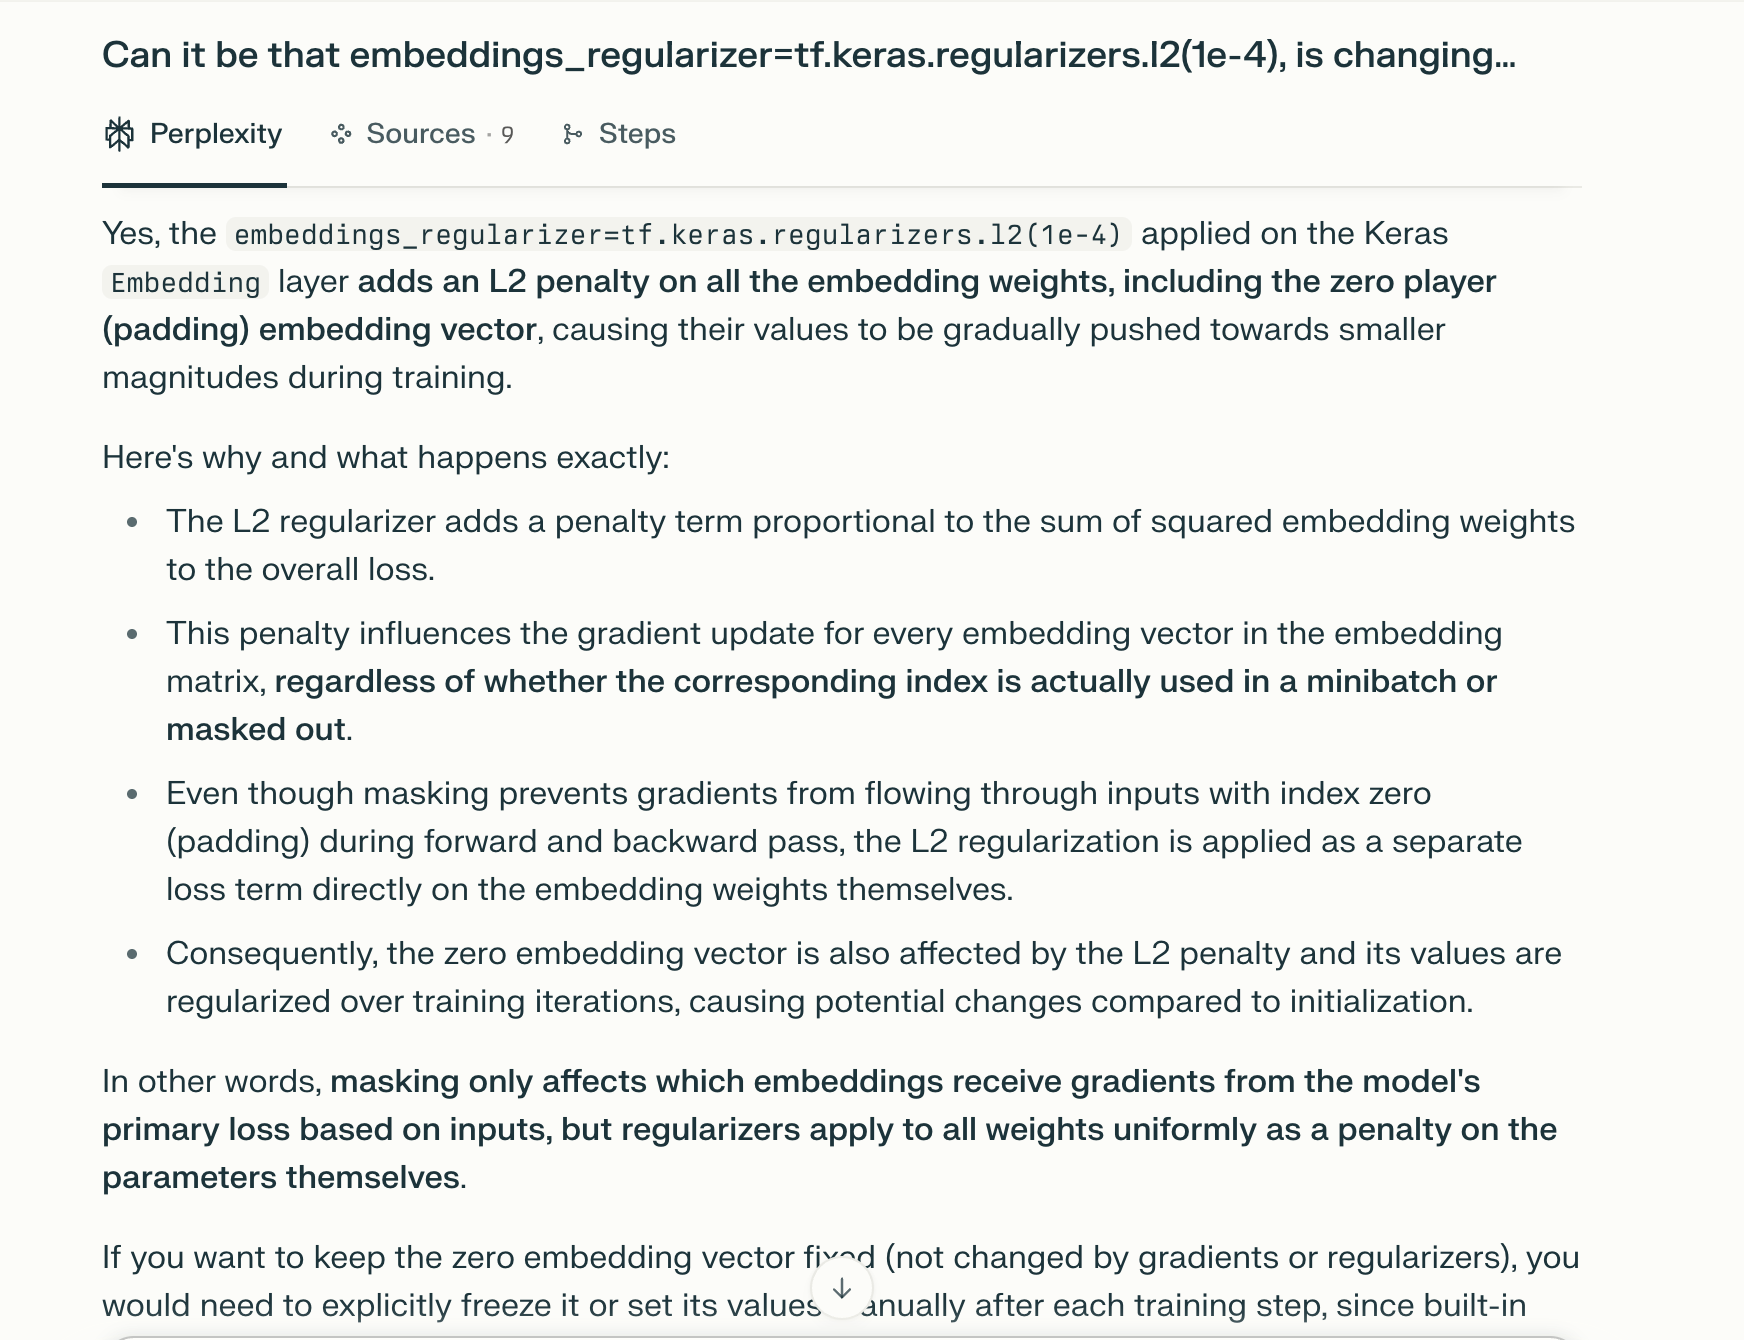

In [5]:
if True:
    # Constants (adjust as needed)
    PLAYER_EMB_DIM = 32
    # NUM_CLASSES = 1  # Binary: win/loss
    
    # Inputs: variable-length teams
    teamA_input = Input(batch_shape=(80, 9), dtype='int32', name='teamA')  # variable-length
    teamB_input = Input(batch_shape=(80, 9), dtype='int32', name='teamB')  # variable-length
    
    # Embedding layer with mask support
    player_embedding = layers.Embedding(
        input_dim=NUM_PLAYERS + 1,
        output_dim=PLAYER_EMB_DIM,
        embeddings_initializer=initializers.GlorotUniform(seed=seed_value),
        mask_zero=True,  # Important: enables automatic masking for padding (0 as pad token)
        # embeddings_regularizer=tf.keras.regularizers.l2(1e-4),
        name='player_embedding'
    )
    
    # Embed team players
    teamA_embeds = player_embedding(teamA_input)  # shape: (batch, teamA_len, emb_dim)
    teamB_embeds = player_embedding(teamB_input)
    
    #Self-attention block (respects masks automatically if using Functional API)
    def self_attention_block(x, name_prefix=''):
        attn_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=PLAYER_EMB_DIM,
            dropout=0.1,
            name=f'{name_prefix}_attn'
        )(x, x)
        x = layers.Add(name=f'{name_prefix}_residual')([x, attn_output])
        x = layers.LayerNormalization(name=f'{name_prefix}_norm')(x)
        return x
    
    # # Apply attention
    teamA_attn = self_attention_block(teamA_embeds, 'teamA')
    teamB_attn = self_attention_block(teamB_embeds, 'teamB')
    
    # Global average pooling over valid (non-padded) tokens
    # TF handles masking automatically in GlobalAveragePooling1D if mask_zero=True
    teamA_vector = layers.GlobalAveragePooling1D(name='teamA_avgpool')(teamA_attn)
    teamB_vector = layers.GlobalAveragePooling1D(name='teamB_avgpool')(teamB_attn)
    teamA_vector = teamA_vector
    teamB_vector = teamB_vector 
    
    # Matchup modeling (difference vector)
    matchup_vector = layers.Subtract(name='matchup_diff')([teamA_vector, teamB_vector])
    
    # Concatenate summary representation
    match_input = layers.Concatenate(name='match_features')([teamA_vector, teamB_vector, matchup_vector])
    # match_input = layers.Concatenate(name='match_features')([teamA_vector, teamB_vector])
    
    # Feedforward classification head
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(match_input)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='linear', name='regression_output')(x)

    # Final model
    model = Model(inputs=[teamA_input, teamB_input], outputs=output)
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',   # or 'mean_absolute_error'
                    metrics=['mean_absolute_error']
                 )

    model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ teamA (InputLayer)  │ (80, 9)           │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB (InputLayer)  │ (80, 9)           │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (80, 9, 32)       │        992 │ teamA[0][0],      │
│ (Embedding)         │                   │            │ teamB[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (80, 9)           │          0 │ teamA[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (80, 9)           │          0 │ teamB[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_attn          │ (80, 9, 32)       │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_attn          │ (80, 9, 32)       │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_residual      │ (80, 9, 32)       │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamA_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_residual      │ (80, 9, 32)       │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamB_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_norm          │ (80, 9, 32)       │         64 │ teamA_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or          │ (80, 9)           │          0 │ not_equal[0][0],  │
│ (LogicalOr)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_norm          │ (80, 9, 32)       │         64 │ teamB_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_1        │ (80, 9)           │          0 │ not_equal_1[0][0… │
│ (LogicalOr)         │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_avgpool       │ (80, 32)          │          0 │ teamA_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_avgpool       │ (80, 32)          │          0 │ teamB_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matchup_diff        │ (80, 32)          │          0 │ teamA_avgpool[0]… │
│ (Subtract)          │                   │            │ teamB_avgpool[0]

 Total params: 43,041 (168.13 KB)

 Trainable params: 43,041 (168.13 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assume the following arrays from your dataset generation code:
# teamA_data, teamB_data, labels (all np arrays)

# 1. Train-validation split (80% train, 20% validation)
X_trainA, X_valA, X_trainB, X_valB, y_train, y_val = train_test_split(
    teamA_data, teamB_data, labels, test_size=0.2, random_state=42
)

# 2. Build or import your Keras model (reuse the model creation code from before)
# For example, let's say you have your variable-size team transformer model as 'model'

# 3. Optional: callbacks for monitoring
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate schedule function (step decay example)
def lr_schedule(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10
    if epoch > 0 and epoch % epochs_drop == 0:
        return lr * drop_rate
    return lr

#Instantiate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Or adaptive reduction on plateau (reduce LR when val_loss stalls)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, min_lr=1e-6)


player_embedding_layer = model.get_layer("player_embedding")
embeddings_before_fold = player_embedding_layer.get_weights()[0]
print("Embedding vector for player zero before training:", embeddings_before_fold[0])

print(X_trainA)

# 4. Train the model
history = model.fit(
    [X_trainA, X_trainB],                 # Inputs as a list
    y_train,                              # Targets
    epochs=50,
    batch_size=32,
    validation_data=([X_valA, X_valB], y_val),
    callbacks=[lr_scheduler, reduce_lr, early_stop],
    # callbacks=[early_stop]
)

pe_layer = model.get_layer("player_embedding")
embeddings_after_fold = pe_layer.get_weights()[0]
print("Embedding vector for player zero after training:", embeddings_after_fold[0])

change = np.linalg.norm(embeddings_after_fold[0] - embeddings_before_fold[0])
print("Change in player zero embedding vector:", change)

# 5. Evaluate model performance
loss, accuracy = model.evaluate([X_valA, X_valB], y_val)
print(f"Validation accuracy: {accuracy:.3f}")

Embedding vector for player zero before training: [-0.13428518 -0.0009771   0.1329839  -0.29613775 -0.26009488  0.07811415
  0.15738839 -0.20170173 -0.22916353 -0.27609777  0.27313498 -0.16636868
 -0.01386166 -0.1564296   0.13861132  0.16607106  0.02278191 -0.20447966
  0.00173342 -0.18519947 -0.28682098 -0.11555447 -0.01580417  0.03690901
  0.1996915   0.05639273 -0.11093217  0.16203171 -0.23099054  0.06050453
 -0.12172711  0.21778926]
[[15 19 17 25 24  7 30 14  0]
 [20 18 25 13  5 10 15  2  0]
 [15 27 12 29 19  2 14  0  0]
 [13 29 18 24  4 30 16 20  0]
 [22 18 13 25  1 26 12  2  0]
 [ 7  8 21 28 25 13  0  0  0]
 [ 6 25 13  7  2 16  0  0  0]
 [25 23 21 24 17 28  1 10  0]
 [ 7 16 19 28 21 17  3  4  0]
 [30  8  7 16 12 13 10 19  0]
 [19 27 10 15 13 16  1  5 14]
 [ 2 18 12 21 25 26  0  0  0]
 [ 9  8 13 25 28 20  1 16  2]
 [ 5 27 19 21  9  0  0  0  0]
 [10  3  7 23  6 25  0  0  0]
 [16 22 17 14 21 30 29  7 27]
 [ 5 27  1 11 23  2 19 30  0]
 [18 15 16 11 12 25  9  8  1]
 [10  1  8 28 30 11

2025-08-07 12:33:38.122831: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-08-07 12:33:38.123306: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.2934 - mean_absolute_error: 0.9206 - val_loss: 1.1137 - val_mean_absolute_error: 0.8305 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2007 - mean_absolute_error: 0.8546 - val_loss: 1.0625 - val_mean_absolute_error: 0.8088 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0591 - mean_absolute_error: 0.7859 - val_loss: 1.0326 - val_mean_absolute_error: 0.7945 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9261 - mean_absolute_error: 0.7371 - val_loss: 1.0226 - val_mean_absolute_error: 0.7906 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9153 - mean_absolute_error: 0.7227 - val_loss: 1.0179 - val_mean_absolute_error: 0.7868 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8520 - mean_absolute_error: 0.6960 - val_loss: 0.9930 - val_mean_absolute_error: 0.7741 - learnin

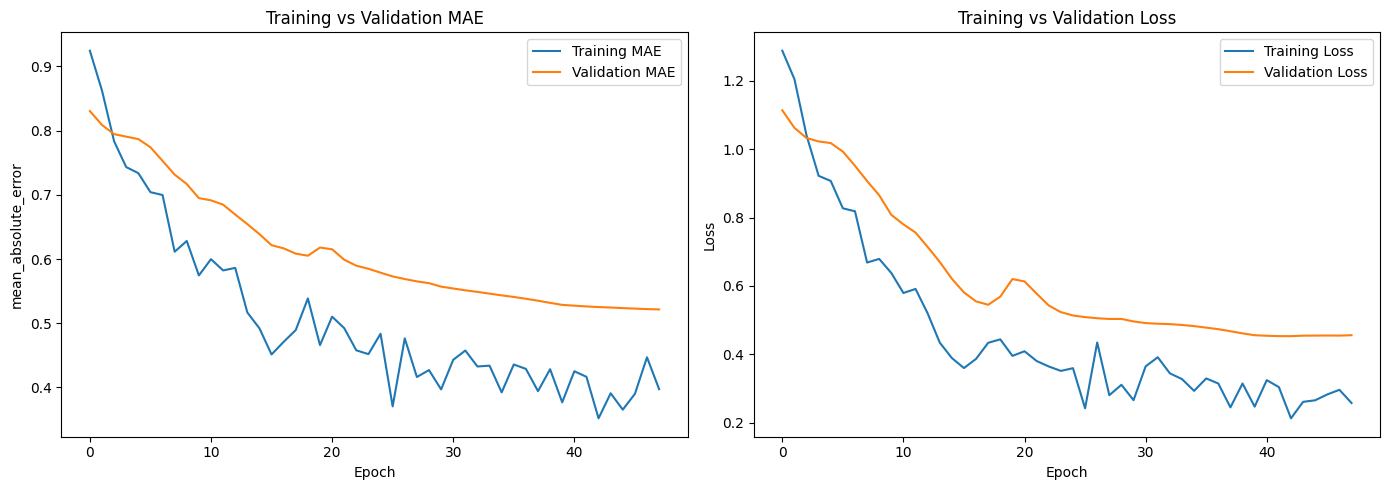

In [7]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by your call to model.fit(...)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.title('Training vs Validation MAE')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Predicting for the match

In [8]:
teamA_players = [vitalii_zhebrakovksy, loginov_dmitrii, ivan, andrey_spiridonov, andrey_larionov, andrey_trubicin, veselin]   # player IDs for Team A
teamB_players = [sanya, roman, denys, andrey_spiridonov, andrey_selifonov, oleksandr, alex_akimov]      # player IDs for Team B
teamA_players

NameError: name 'vitalii_zhebrakovksy' is not defined

In [ ]:

MAX_TEAM_SIZE = 9  # Should match model's expected size

# Pad teams to MAX_TEAM_SIZE with 0 (mask token)
def pad_team(players, max_size):
    padded = players + [0]*(max_size - len(players))
    return np.array(padded)

teamA_input = pad_team(teamA_players, MAX_TEAM_SIZE)
teamB_input = pad_team(teamB_players, MAX_TEAM_SIZE)

# Add batch dimension: shape (1, MAX_TEAM_SIZE)
teamA_input = np.expand_dims(teamA_input, axis=0)
teamB_input = np.expand_dims(teamB_input, axis=0)

# Predict using the trained model
prediction = model.predict([teamA_input, teamB_input])
print(prediction)
# If model output is sigmoid probability of Team A win:
# prob_teamA_wins = prediction[0][0]

# print(f"Predicted probability that Team A wins: {prob_teamA_wins:.3f}")

# # Optional: Decide class label
# predicted_label = 1 if prob_teamA_wins > 0.5 else 0
# print("Predicted winner:", "Team A" if predicted_label == 1 else "Team B")


In [ ]:

# teamA_pls = teamA_players
# print(" Team A players: ", teamA_pls)
# teamA_str = player_strengths[teamA_pls]
# print(f" Team A palyers' stregths:{teamA_str}, Total: {teamA_str.sum()}")

# teamB_pls = teamB_players
# print(" Team B players: ", teamB_pls)
# teamB_str = player_strengths[teamB_pls]
# print(f" Team B palyers' stregths:{teamB_str}, Total: {teamB_str.sum()}")
# # print(" Label (Team A wins=1):", labels[i])

In [ ]:
# outcome = teamA_strength - teamB_strength
# competition_res = 1 if outcome > 0 else 0
# competition_res

## Extracting embeddings of players

In [8]:
# Direct reference to layer
player_embeddings = player_embedding.get_weights()[0]
print(player_embeddings.shape)  # (NUM_PLAYERS, PLAYER_EMB_DIM)

(31, 32)


In [9]:
print(player_embedding.input_dim)  # should show actual input_dim in the model
print(player_embedding.embeddings.shape)  

31
(31, 32)


## Try to initialize embeddings based on content based similarity.

TODO Use MPS(not sure) manifold approach to get initial embeddings

## UMAP and visualizing players in 3D

/opt/anaconda3/envs/footballman/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


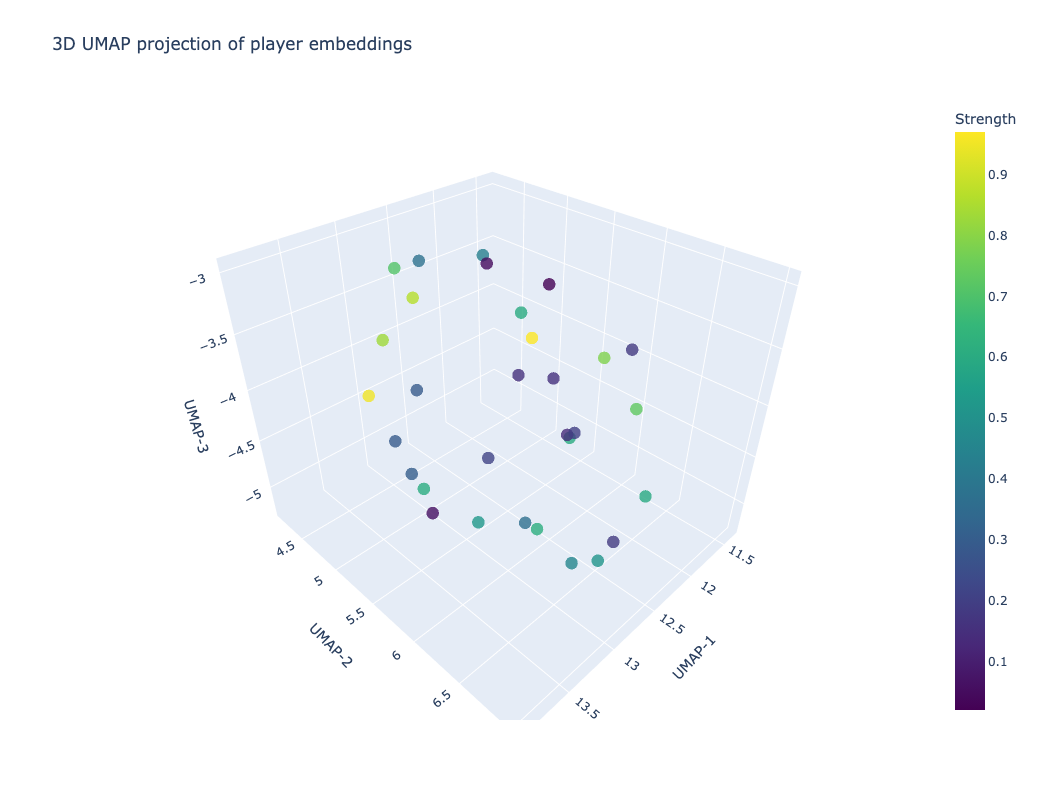

In [10]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Generate test embeddings and labels (replace these with actual data)
np.random.seed(42)
# player_embeddings = np.random.rand(32, 32)
# labels = [f'{name}' for name in team_dict.values()]
labels_points = [f'Player {idx}:{name}' for idx, name in enumerate(player_strengths)]


# Embed to 3D
reducer = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = reducer.fit_transform(player_embeddings)

# Create interactive 3D scatter plot
fig = go.Figure(
    data=[go.Scatter3d(
        x=embeddings_3d[:, 0],
        y=embeddings_3d[:, 1],
        z=embeddings_3d[:, 2],
        mode='markers',
        marker=dict(
            size=7,
            color=player_strengths,       # Color by this array
            colorscale='Viridis',         # Choose a colorscale
            colorbar=dict(title='Strength'),
            opacity=0.8
        ),
        text=labels_points,          # Hover labels
        hoverinfo='text'
    )]
)

fig.update_layout(
    title="3D UMAP projection of player embeddings",
    width=1000,             # <-- Change this to your desired width in pixels
    height=800,  
    scene=dict(
        xaxis_title="UMAP-1",
        yaxis_title="UMAP-2",
        zaxis_title="UMAP-3"
    )
)

fig.show()


In [11]:
embeddings_3d.shape

(31, 3)

## Calculate correlation of the embeddings with the original base strengths

In [12]:
import numpy as np
from scipy.stats import pearsonr

# Assuming these variables from your setup:
# player_strengths: numpy array of shape (num_players,)
# embeddings_3d: numpy array of shape (num_players, 3) -- UMAP 3D projections

num_players = player_strengths.shape[0]
correlations = []
print(player_strengths.shape)
print(embeddings_3d[:, 0].shape)
for dim in range(3):
    corr, p_value = pearsonr(embeddings_3d[:, dim], player_strengths)
    correlations.append((corr, p_value))
    print(f"Dimension {dim + 1} correlation with base strengths: r = {corr:.4f}, p-value = {p_value:.4g}")

# Optionally, compute average absolute correlation across all 3 dimensions
avg_abs_corr = np.mean([abs(c[0]) for c in correlations])
print(f"Average absolute correlation across 3 components: {avg_abs_corr:.4f}")


(31,)
(31,)
Dimension 1 correlation with base strengths: r = -0.0036, p-value = 0.9846
Dimension 2 correlation with base strengths: r = -0.1845, p-value = 0.3204
Dimension 3 correlation with base strengths: r = 0.0096, p-value = 0.959
Average absolute correlation across 3 components: 0.0659


## Use SHAP values to explain individual contributions

In [13]:
import shap
shap.__version__

'0.48.0'

In [14]:
background = [X_trainA, X_trainB]
print(np.array(background).shape)
print(background) 

(2, 80, 9)
[array([[15, 19, 17, 25, 24,  7, 30, 14,  0],
       [20, 18, 25, 13,  5, 10, 15,  2,  0],
       [15, 27, 12, 29, 19,  2, 14,  0,  0],
       [13, 29, 18, 24,  4, 30, 16, 20,  0],
       [22, 18, 13, 25,  1, 26, 12,  2,  0],
       [ 7,  8, 21, 28, 25, 13,  0,  0,  0],
       [ 6, 25, 13,  7,  2, 16,  0,  0,  0],
       [25, 23, 21, 24, 17, 28,  1, 10,  0],
       [ 7, 16, 19, 28, 21, 17,  3,  4,  0],
       [30,  8,  7, 16, 12, 13, 10, 19,  0],
       [19, 27, 10, 15, 13, 16,  1,  5, 14],
       [ 2, 18, 12, 21, 25, 26,  0,  0,  0],
       [ 9,  8, 13, 25, 28, 20,  1, 16,  2],
       [ 5, 27, 19, 21,  9,  0,  0,  0,  0],
       [10,  3,  7, 23,  6, 25,  0,  0,  0],
       [16, 22, 17, 14, 21, 30, 29,  7, 27],
       [ 5, 27,  1, 11, 23,  2, 19, 30,  0],
       [18, 15, 16, 11, 12, 25,  9,  8,  1],
       [10,  1,  8, 28, 30, 11, 13, 23,  3],
       [ 3, 15, 21, 10, 25,  0,  0,  0,  0],
       [11, 10, 21, 28,  2,  7,  0,  0,  0],
       [11,  1, 17,  7, 21, 20, 10,  0,  0]

In [15]:
combined_background.shape

NameError: name 'combined_background' is not defined

In [105]:

# [X_trainA, X_trainB],                 # Inputs as a list
#     y_train,            

# background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

background = [X_trainA, X_trainB]
# print(background)
print(X_trainA.shape)

def model_wrapper(combined_input):
    # combined_input.shape = (samples, d1 + d2)
    
    X1 = combined_input[:, :9]  # first d1 features
    X2 = combined_input[:, 9:]  # remaining d2 features
    
    # Depending on the model input shape, possibly reshape if needed
    # For example, if input expects 2D arrays directly, no reshape needed
    # If input expects 3D or more, reshape here
    
    # Make prediction
    preds = model.predict([X1, X2])
    
    return preds


combined_background = np.concatenate(background, axis=1)  
# Initialize the SHAP DeepExplainer
explainer = shap.KernelExplainer(model_wrapper, combined_background)

# Explain predictions for some test samples
shap_values = explainer.shap_values(combined_background[:])

# Create a plot of the SHAP values for these samples
# shap.image_plot(shap_values, -[X_trainA[1:5], X_trainB[1:5] ])

(80, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


2025-08-06 19:23:09.393814: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-06 19:23:09.394851: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5210/5210 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


  1%|██▏                                                                                                                                                                         | 1/80 [00:06<08:11,  6.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 100/5210 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

2025-08-06 19:23:15.665503: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-06 19:23:15.665749: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5210/5210 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


  2%|████▎                                                                                                                                                                       | 2/80 [00:12<07:46,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
  88/5210 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

2025-08-06 19:23:21.470285: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-06 19:23:21.470508: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 536/5210 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

  2%|████▎                                                                                                                                                                       | 2/80 [00:12<08:15,  6.35s/it]


KeyboardInterrupt: 

In [98]:
shap_values.shape

(80, 18, 1)

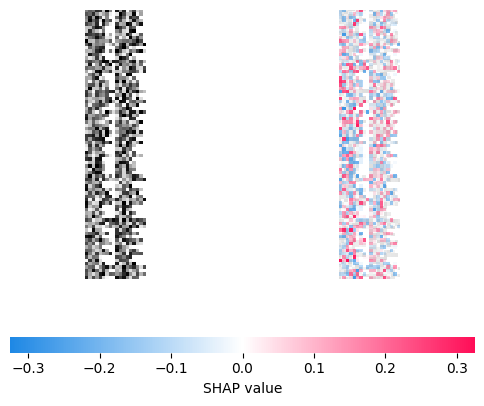

In [100]:
shap.image_plot(shap_values, -combined_background)

In [107]:
shap_values.shape

(80, 18, 1)

In [101]:
explained_games = combined_background

aggregated_contribs = {}

for shap_contribs, game in zip(shap_values, explained_games):
    print(f"shap_contribs: {shap_contribs} for game: {game}")
    for idx, player in enumerate(game):
        if player == 0 and shap_contribs[idx] != 0:
            print(f"Mask contributed ( player: {player}: idx: {idx}): shap_contribs: {shap_contribs[idx]} for game: {game}")
        aggregated_contribs[player] = aggregated_contribs.get(player, 0) + shap_contribs[idx]
    print("="*100)

shap_contribs: [[-0.08973786]
 [-0.16147472]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.08128935]
 [ 0.22654933]
 [ 0.        ]
 [ 0.        ]
 [-0.05820405]
 [ 0.        ]
 [ 0.        ]
 [-0.17702604]
 [ 0.04649548]
 [ 0.10263992]
 [ 0.05574589]
 [ 0.10973657]
 [ 0.        ]] for game: [15 19 17 25 24  7 30 14  0 27 12 26  1 13 22  5 10  0]
shap_contribs: [[-0.0818073 ]
 [ 0.        ]
 [ 0.        ]
 [-0.05663403]
 [ 0.08590839]
 [-0.05286219]
 [-0.09418444]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.17310822]
 [ 0.05467787]
 [-0.09298069]
 [ 0.        ]
 [ 0.12147046]
 [-0.13580532]
 [ 0.        ]
 [ 0.        ]] for game: [20 18 25 13  5 10 15  2  0  3 30 22  7  8 29  1 11  0]
shap_contribs: [[-0.06116361]
 [-0.1566044 ]
 [ 0.02723565]
 [-0.15812532]
 [-0.13223467]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.03496945]
 [ 0.04048867]
 [ 0.11716128]
 [ 0.0720381 ]
 [ 0.04774331]
 [ 0.        ]
 [ 0.        ]] for game: 

In [102]:
aggregated_contribs

{np.int64(15): array([-0.4654597]),
 np.int64(19): array([-1.10205467]),
 np.int64(17): array([-1.48601681]),
 np.int64(25): array([1.4371453]),
 np.int64(24): array([2.03463411]),
 np.int64(7): array([0.7826703]),
 np.int64(30): array([-1.18559007]),
 np.int64(14): array([-0.55199969]),
 np.int64(0): array([-0.3854351]),
 np.int64(27): array([-2.81056076]),
 np.int64(12): array([0.37208505]),
 np.int64(26): array([-1.48549847]),
 np.int64(1): array([1.16758759]),
 np.int64(13): array([-0.15692509]),
 np.int64(22): array([0.98351441]),
 np.int64(5): array([2.43362929]),
 np.int64(10): array([-0.50655261]),
 np.int64(20): array([-1.07747197]),
 np.int64(18): array([1.50060023]),
 np.int64(2): array([0.1352433]),
 np.int64(3): array([0.41781885]),
 np.int64(8): array([2.47588957]),
 np.int64(29): array([0.05491893]),
 np.int64(11): array([5.43517564]),
 np.int64(4): array([0.21325578]),
 np.int64(16): array([-0.38016448]),
 np.int64(9): array([-1.50204396]),
 np.int64(28): array([-3.2773

In [103]:
aggregated_contribs_sorted = sorted(aggregated_contribs.items(), key=lambda item: item[1])
aggregated_contribs_sorted

[(np.int64(23), array([-3.98799902])),
 (np.int64(28), array([-3.27738239])),
 (np.int64(27), array([-2.81056076])),
 (np.int64(9), array([-1.50204396])),
 (np.int64(17), array([-1.48601681])),
 (np.int64(26), array([-1.48549847])),
 (np.int64(30), array([-1.18559007])),
 (np.int64(19), array([-1.10205467])),
 (np.int64(20), array([-1.07747197])),
 (np.int64(21), array([-0.55770353])),
 (np.int64(14), array([-0.55199969])),
 (np.int64(10), array([-0.50655261])),
 (np.int64(15), array([-0.4654597])),
 (np.int64(0), array([-0.3854351])),
 (np.int64(16), array([-0.38016448])),
 (np.int64(13), array([-0.15692509])),
 (np.int64(29), array([0.05491893])),
 (np.int64(2), array([0.1352433])),
 (np.int64(4), array([0.21325578])),
 (np.int64(12), array([0.37208505])),
 (np.int64(3), array([0.41781885])),
 (np.int64(7), array([0.7826703])),
 (np.int64(22), array([0.98351441])),
 (np.int64(1), array([1.16758759])),
 (np.int64(25), array([1.4371453])),
 (np.int64(6), array([1.4746897])),
 (np.int64

/var/folders/sg/nff54zj50zl8mzy2j3lnw34w0000gn/T/ipykernel_51190/989279722.py:1: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.

/opt/anaconda3/envs/footballman/lib/python3.12/site-packages/shap/plots/_beeswarm.py:723: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



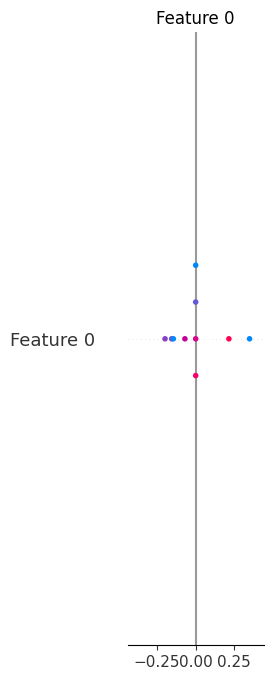

In [48]:
shap.summary_plot(shap_values, combined_background[0:10])

In [54]:
print(combined_background.shape)
combined_background_reshaped = np.expand_dims(combined_background, axis=2)
combined_background_reshaped.shape

(80, 18)


(80, 18, 1)

In [58]:
shap.initjs()

In [62]:
shap_values.shape

(10, 18, 1)

In [64]:
combined_background_reshaped[0:10].shape

(10, 18, 1)

In [66]:
# For a single instance
shap.force_plot(explainer.expected_value, shap_values[1], -combined_background_reshaped[0:10][1])

# For multiple instances (summary)
# shap.force_plot(explainer.expected_value, shap_values, -combined_background_reshaped[0:10])